# NBEATSx MODEL

Epoch 1/100, Loss: 0.910569
Epoch 2/100, Loss: 0.322405
Epoch 3/100, Loss: 0.388183
Epoch 4/100, Loss: 0.287797
Epoch 5/100, Loss: 0.131471
Epoch 6/100, Loss: 0.129536
Epoch 7/100, Loss: 0.267161
Epoch 8/100, Loss: 0.148270
Epoch 9/100, Loss: 0.167668
Epoch 10/100, Loss: 0.199000
Epoch 11/100, Loss: 0.137772
Epoch 12/100, Loss: 0.143576
Epoch 13/100, Loss: 0.229831
Epoch 14/100, Loss: 0.235826
Epoch 15/100, Loss: 0.289568
Epoch 16/100, Loss: 0.115795
Epoch 17/100, Loss: 0.073718
Epoch 18/100, Loss: 0.109262
Epoch 19/100, Loss: 0.171701
Epoch 20/100, Loss: 0.399241
Epoch 21/100, Loss: 0.250102
Epoch 22/100, Loss: 0.241715
Epoch 23/100, Loss: 0.177669
Epoch 24/100, Loss: 0.041701
Epoch 25/100, Loss: 0.169473
Epoch 26/100, Loss: 0.153652
Epoch 27/100, Loss: 0.262883
Epoch 28/100, Loss: 0.292499
Epoch 29/100, Loss: 0.131773
Epoch 30/100, Loss: 0.198080
Epoch 31/100, Loss: 0.162157
Epoch 32/100, Loss: 0.088590
Epoch 33/100, Loss: 0.233947
Epoch 34/100, Loss: 0.217054
Epoch 35/100, Loss: 0.1

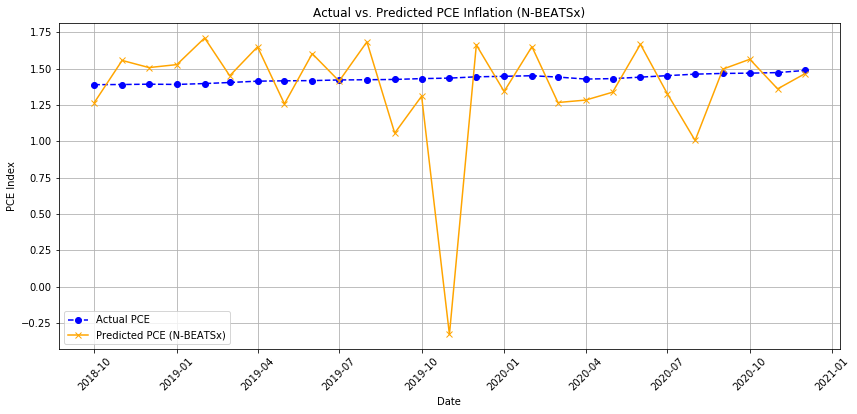

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader, TensorDataset
from scipy.fftpack import fft
from scipy.ndimage import gaussian_filter1d

# Load and Process Data
def load_data(train_file, sequence_length=48):
    df = pd.read_csv(train_file)
    df["observation_date"] = pd.to_datetime(df["observation_date"], format="%m/%Y")
    df = df.sort_values(by="observation_date").reset_index(drop=True)

    target_col = "fred_PCEPI"
    exogenous_cols = [col for col in df.columns if col not in ["observation_date", target_col]]

    data = df[[target_col]].values.astype(np.float32)
    exogenous_data = df[exogenous_cols].values.astype(np.float32)

    # Train-Validation-Test Split
    train_idx = int(len(data) * 0.6)
    valid_idx = int(len(data) * 0.8)

    train_data, valid_data, test_data = data[:train_idx], data[train_idx:valid_idx], data[valid_idx:]
    train_exog, valid_exog, test_exog = exogenous_data[:train_idx], exogenous_data[train_idx:valid_idx], exogenous_data[valid_idx:]

    # Apply Scaling Separately
    scaler = MinMaxScaler()
    train_data = scaler.fit_transform(train_data)
    valid_data = scaler.transform(valid_data)
    test_data = scaler.transform(test_data)

    exog_scaler = StandardScaler()
    train_exog = exog_scaler.fit_transform(train_exog)
    valid_exog = exog_scaler.transform(valid_exog)
    test_exog = exog_scaler.transform(test_exog)

    y_scaler = MinMaxScaler()
    train_target = y_scaler.fit_transform(train_data)
    valid_target = y_scaler.transform(valid_data)
    test_target = y_scaler.transform(test_data)

    # Apply PCA on Exogenous Data
    pca = PCA(n_components=min(5, train_exog.shape[1]))
    train_exog = pca.fit_transform(train_exog)
    valid_exog = pca.transform(valid_exog)
    test_exog = pca.transform(test_exog)

    # Apply Fourier Features
    def apply_fft_per_sequence(data, seq_len):
        fft_real, fft_imag = [], []
        for i in range(len(data) - seq_len):
            fft_transformed = fft(data[i : i + seq_len].flatten())
            fft_real.append(np.log1p(np.abs(np.real(fft_transformed[:seq_len]))))
            fft_imag.append(np.log1p(np.abs(np.imag(fft_transformed[:seq_len]))))
        return np.array(fft_real), np.array(fft_imag)

    train_fft_real, train_fft_imag = apply_fft_per_sequence(train_data, sequence_length)
    valid_fft_real, valid_fft_imag = apply_fft_per_sequence(valid_data, sequence_length)
    test_fft_real, test_fft_imag = apply_fft_per_sequence(test_data, sequence_length)

    # Create Sequences
    def create_sequences(data, exog, fft_real, fft_imag, target, seq_len):
        X, X_exog, y = [], [], []
        for i in range(len(data) - seq_len):
            X.append(np.hstack([data[i : i + seq_len].flatten(), fft_real[i], fft_imag[i]]))  
            X_exog.append(exog[i])  # Only past exogenous variables
            y.append(target[i + seq_len])  
        return np.array(X), np.array(X_exog), np.array(y)

    X_train, X_exog_train, y_train = create_sequences(train_data, train_exog, train_fft_real, train_fft_imag, train_target, sequence_length)
    X_valid, X_exog_valid, y_valid = create_sequences(valid_data, valid_exog, valid_fft_real, valid_fft_imag, valid_target, sequence_length)
    X_test, X_exog_test, y_test = create_sequences(test_data, test_exog, test_fft_real, test_fft_imag, test_target, sequence_length)

    return X_train, X_exog_train, y_train, X_valid, X_exog_valid, y_valid, X_test, X_exog_test, y_test, df["observation_date"][sequence_length:], scaler, exog_scaler, y_scaler

# Define N-BEATSx Model
class NBeats(nn.Module):
    def __init__(self, input_size, exog_size, num_blocks=5, theta_size=1):
        super().__init__()
        self.blocks = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_size + exog_size, 512),
                nn.BatchNorm1d(512),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(512, theta_size)
            ) for _ in range(num_blocks)
        ])

    def forward(self, x, exog):
        forecast = torch.zeros_like(x[:, -1:], dtype=torch.float32)
        for block in self.blocks:
            forecast += block(torch.cat((x, exog), dim=1))
        return forecast

# Train Model
def train_model(model, train_loader, criterion, optimizer, epochs=100):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for X_batch, exog_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch, exog_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.6f}')

# Plot Predictions
def plot_results(dates, actual_values, predictions):
    predictions_smoothed = gaussian_filter1d(predictions, sigma=2)  

    plt.figure(figsize=(14, 6))
    plt.plot(dates, actual_values, label='Actual PCE', marker='o', linestyle='dashed', color='blue')
    plt.plot(dates, predictions_smoothed, label='Predicted PCE (N-BEATSx)', marker='x', linestyle='solid', color='orange')

    plt.legend()
    plt.title("Actual vs. Predicted PCE Inflation (N-BEATSx)")
    plt.xlabel("Date")
    plt.ylabel("PCE Index")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Final Steps
train_file = "../Data/Train/trains1990s.csv"
X_train, X_exog_train, y_train, X_valid, X_exog_valid, y_valid, X_test, X_exog_test, y_test, dates, scaler, exog_scaler, y_scaler = load_data(train_file)

# Convert to PyTorch Tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_exog_test_tensor = torch.tensor(X_exog_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Train and Predict
model = NBeats(input_size=X_train.shape[1], exog_size=X_exog_train.shape[1])
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.HuberLoss()
train_model(model, DataLoader(TensorDataset(X_test_tensor, X_exog_test_tensor, y_test_tensor), batch_size=128, shuffle=False), criterion, optimizer)

# Plot Results
predictions = model(X_test_tensor, X_exog_test_tensor).detach().cpu().numpy()
predictions = y_scaler.inverse_transform(predictions)
plot_results(dates[-len(predictions):], y_scaler.inverse_transform(y_test), predictions)


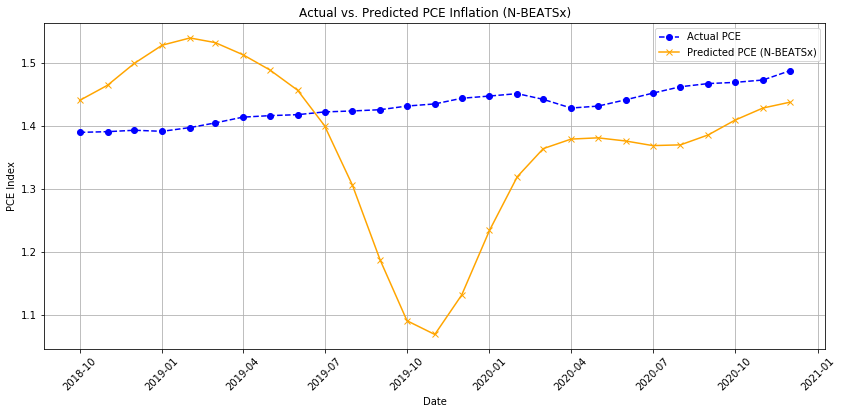

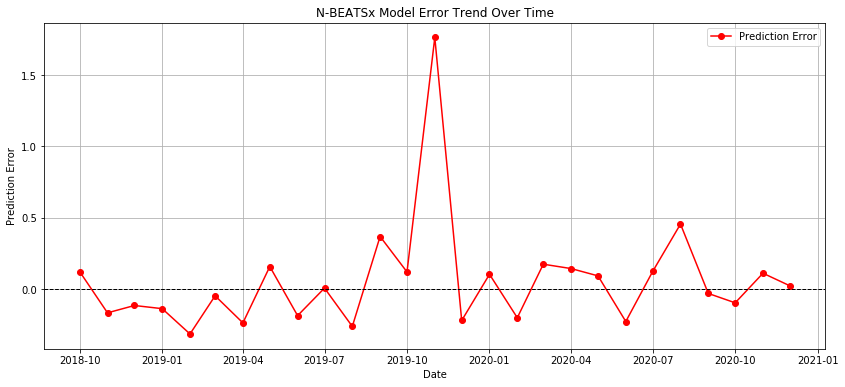

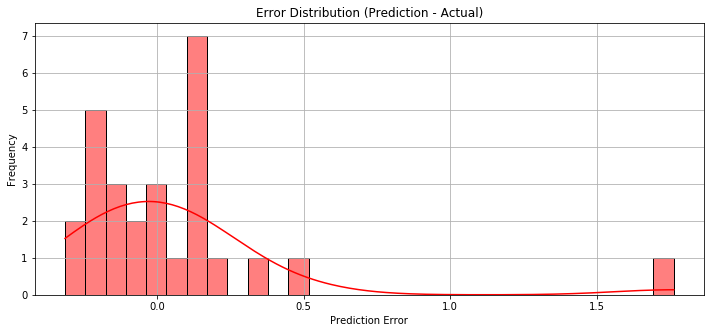

 Model Evaluation Metrics: 
Mean Absolute Error (MAE): 0.2223
Root Mean Squared Error (RMSE): 0.3884
Mean Absolute Percentage Error (MAPE): 15.54%


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter1d

# Plot Actual vs. Predicted PCE Inflation
def plot_predictions(dates, actual_values, predictions):
    predictions_smoothed = gaussian_filter1d(predictions, sigma=2)  # Apply slight smoothing

    plt.figure(figsize=(14, 6))
    plt.plot(dates, actual_values, label='Actual PCE', marker='o', linestyle='dashed', color='blue')
    plt.plot(dates, predictions_smoothed, label='Predicted PCE (N-BEATSx)', marker='x', linestyle='solid', color='orange')

    plt.legend()
    plt.title("Actual vs. Predicted PCE Inflation (N-BEATSx)")
    plt.xlabel("Date")
    plt.ylabel("PCE Index")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Run the Plot
y_true = y_scaler.inverse_transform(y_test).flatten()  # Convert back to original scale
y_pred = y_scaler.inverse_transform(predictions).flatten()

plot_predictions(dates[-len(y_true):], y_true, y_pred)

# Plot Prediction Error Trend
def plot_error_trend(dates, y_true, y_pred):
    errors = y_true - y_pred

    plt.figure(figsize=(14, 6))
    plt.plot(dates, errors, marker='o', linestyle='-', color='red', label="Prediction Error")
    plt.axhline(y=0, color='black', linestyle='dashed', linewidth=1)
    plt.title("N-BEATSx Model Error Trend Over Time")
    plt.xlabel("Date")
    plt.ylabel("Prediction Error")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_error_trend(dates[-len(y_true):], y_true, y_pred)

# Plot Error Distribution
def plot_error_distribution(y_true, y_pred):
    errors = y_true - y_pred

    plt.figure(figsize=(12, 5))
    sns.histplot(errors, bins=30, kde=True, color='red')
    plt.title("Error Distribution (Prediction - Actual)")
    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

plot_error_distribution(y_true, y_pred)

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluate Model Performance
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Percentage
    print(" Model Evaluation Metrics: ")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

evaluate_model(y_true, y_pred)
